In [367]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import mstats
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from tensorflow.keras.callbacks import EarlyStopping

In [368]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [369]:
df = pd.read_csv('../../data/pre_train/aapl.csv')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df.astype(float)
df = df.dropna()

In [370]:
y = df['log_close']
X = df.drop('log_close', axis=1)

In [371]:
def create_sequences(X, y, time_steps=60):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X.iloc[i:i + time_steps].values)
        y_seq.append(y.iloc[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

In [372]:
def evaluate_model(y_pred_train, y_pred_test, y_train, y_test):
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    print("MAE train:", mae_train)
    print("MAE test:", mae_test)
    print("RMSE train:", rmse_train)
    print("RMSE test:", rmse_test)
    print("R2 train:", r2_train)
    print("R2 test:", r2_test)

In [373]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [374]:
X_train_seq, y_train_seq = create_sequences(X_train, y_train)
X_test_seq, y_test_seq = create_sequences(X_test, y_test)

In [375]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [376]:
X_train_seq_flat = X_train_seq.reshape(-1, X_train_seq.shape[-1])
X_test_seq_flat = X_test_seq.reshape(-1, X_test_seq.shape[-1])

In [377]:
X_train_seq_scaled = scaler_X.fit_transform(X_train_seq_flat).reshape(X_train_seq.shape)
X_test_seq_scaled = scaler_X.transform(X_test_seq_flat).reshape(X_test_seq.shape)

In [378]:
y_train_seq_scaled = scaler_y.fit_transform(y_train_seq.reshape(-1, 1)).flatten()
y_test_seq_scaled = scaler_y.transform(y_test_seq.reshape(-1, 1)).flatten()

In [379]:
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train_seq_scaled.shape[1], X_train_seq_scaled.shape[2]),
         kernel_regularizer=l2(0.0005)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.0005)),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [380]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [381]:
history = model.fit(X_train_seq_scaled, y_train_seq_scaled,
                    epochs=50, batch_size=64,
                    validation_data=(X_test_seq_scaled, y_test_seq_scaled),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - loss: 0.1664 - mae: 0.2908 - val_loss: 0.0680 - val_mae: 0.1888
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0495 - mae: 0.1059 - val_loss: 0.0385 - val_mae: 0.0851
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0385 - mae: 0.0708 - val_loss: 0.0353 - val_mae: 0.0703
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0363 - mae: 0.0666 - val_loss: 0.0323 - val_mae: 0.0553
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0344 - mae: 0.0623 - val_loss: 0.0294 - val_mae: 0.0375
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0333 - mae: 0.0621 - val_loss: 0.0332 - val_mae: 0.0781
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0310 - mae: 0.0554 - val_loss: 0.0303 - val_mae: 0.0642
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0296 - mae: 0.0522 - val_loss: 0.0331 - val_mae: 0.0882
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0

In [382]:
y_pred_train_scaled = model.predict(X_train_seq_scaled)
y_pred_test_scaled = model.predict(X_test_seq_scaled)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [383]:
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).flatten()
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()
y_train_true = scaler_y.inverse_transform(y_train_seq_scaled.reshape(-1, 1)).flatten()
y_test_true = scaler_y.inverse_transform(y_test_seq_scaled.reshape(-1, 1)).flatten()

In [384]:
evaluate_model(y_pred_train, y_pred_test, y_train_true, y_test_true)

MAE train: 0.03882332631708916
MAE test: 0.04559102182103745
RMSE train: 0.04718215938698569
RMSE test: 0.054496613599602756
R2 train: 0.9603734906513504
R2 test: 0.7873427925674178


In [385]:
def plot_predictions(y_test_real, y_pred_test_real):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_real, label="Real", color="blue")
    plt.plot(y_pred_test_real, label="Predicho", color="orange")
    plt.title("Predicciones vs. Valores Reales")
    plt.legend()
    plt.show()

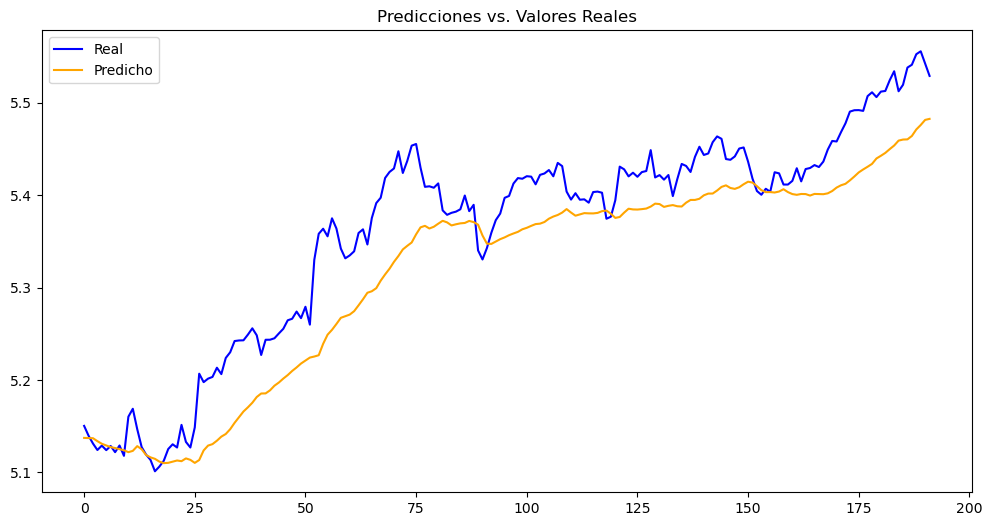

In [386]:
plot_predictions(y_test_true, y_pred_test)

In [387]:
print("Varianza de y_train_true:", np.var(y_train_true))
print("Varianza de y_test_true:", np.var(y_test_true))

Varianza de y_train_true: 0.056178457325936036
Varianza de y_test_true: 0.013965578358146815


In [388]:
print("Mínimo y_train_true:", np.min(y_train_true))
print("Máximo y_train_true:", np.max(y_train_true))
print("Mínimo y_test_true:", np.min(y_test_true))
print("Máximo y_test_true:", np.max(y_test_true))


Mínimo y_train_true: 4.068407799265662
Máximo y_train_true: 5.282836520918564
Mínimo y_test_true: 5.101234688522624
Máximo y_test_true: 5.555806320403068


In [389]:
print("Varianza de y_pred_train:", np.var(y_pred_train))
print("Varianza de y_pred_test:", np.var(y_pred_test))


Varianza de y_pred_train: 0.05158177
Varianza de y_pred_test: 0.012666515
